In [2]:
# create subset of dnb records (10000 entries)

import psycopg2
import json
from dotenv import load_dotenv
import os
from typing import Dict, List, Tuple

# Umgebungsvariablen laden
load_dotenv()


def connect_to_db() -> psycopg2.extensions.connection:
    """Datenbankverbindung herstellen"""
    return psycopg2.connect(
        host=os.getenv("DB_HOST"),
        port=os.getenv("DB_PORT"),
        database=os.getenv("DB_NAME"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
    )


def get_base_conditions() -> str:
    """Basisbedingungen für die Datenbankabfrage"""
    return """
        num_pages <= 200 
        AND abstract_num IS NOT NULL 
        AND abstract_num != '0'
    """


def get_category_counts(cur: psycopg2.extensions.cursor) -> Dict[str, int]:
    """Ermittelt die Anzahl der Einträge pro DDC-Kategorie"""
    base_conditions = get_base_conditions()
    category_counts = {}

    for ddc in range(10):
        ddc_str = str(ddc)
        cur.execute(
            f"""
            SELECT COUNT(*)
            FROM dnb_records
            WHERE {base_conditions}
              AND SUBSTRING(ddc FROM 1 FOR 1) = %s
        """,
            (ddc_str,),
        )
        category_counts[ddc_str] = cur.fetchone()[0]

    return category_counts


def create_balanced_subset(category_counts: Dict[str, int], total_needed: int) -> Dict[str, int]:
    """
    Erstellt ein ausgewogenes Subset der Daten durch rotierende Auswahl.
    Verteilt die Einträge gleichmäßig auf alle Kategorien, die noch Einträge haben.
    """
    entries_needed = {ddc: 0 for ddc in category_counts.keys()}
    remaining_entries = {ddc: count for ddc, count in category_counts.items()}
    entries_to_allocate = total_needed

    while entries_to_allocate > 0:
        # Nur Kategorien berücksichtigen, die noch Einträge haben
        available_categories = [ddc for ddc, count in remaining_entries.items() if count > 0]

        if not available_categories:
            break

        # Berechne, wie viele Einträge pro Kategorie in dieser Runde verteilt werden
        entries_per_category = max(1, entries_to_allocate // len(available_categories))

        for ddc in available_categories:
            # Nimm den kleineren Wert: verfügbare Einträge oder zu verteilende Einträge
            entries_to_take = min(remaining_entries[ddc], entries_per_category, entries_to_allocate)

            entries_needed[ddc] += entries_to_take
            remaining_entries[ddc] -= entries_to_take
            entries_to_allocate -= entries_to_take

            if entries_to_allocate <= 0:
                break

    return entries_needed


def create_subset_table(cur: psycopg2.extensions.cursor, entries_needed: Dict[str, int]) -> None:
    """Erstellt eine neue Tabelle für das Subset"""
    cur.execute(
        """
        DROP TABLE IF EXISTS dnb_records_subset;
        CREATE TABLE dnb_records_subset AS
        WITH ranked_records AS (
            SELECT *,
                ROW_NUMBER() OVER (
                    PARTITION BY SUBSTRING(ddc FROM 1 FOR 1)
                    ORDER BY RANDOM()
                ) as row_num
            FROM dnb_records
            WHERE num_pages <= 200 
                AND abstract_num IS NOT NULL 
                AND abstract_num != '0'
        )
        SELECT *
        FROM ranked_records r
        WHERE row_num <= (
            SELECT count::integer  -- Explizite Typkonvertierung zu INTEGER
            FROM jsonb_each_text(%s) as t(ddc, count)
            WHERE t.ddc = SUBSTRING(r.ddc FROM 1 FOR 1)
        );
    """,
        (json.dumps(entries_needed),),
    )


def create_subset_indices(cur: psycopg2.extensions.cursor) -> None:
    """Erstellt Indizes für die Subset-Tabelle"""
    cur.execute(
        """
        CREATE INDEX idx_subset_ddc ON dnb_records_subset(ddc);
        CREATE INDEX idx_subset_id ON dnb_records_subset(id);
    """
    )


def verify_subset(cur: psycopg2.extensions.cursor, entries_needed: Dict[str, int]) -> None:
    """Überprüft, ob das Subset korrekt erstellt wurde"""
    cur.execute(
        """
        SELECT SUBSTRING(ddc FROM 1 FOR 1) as ddc_category, COUNT(*) as count
        FROM dnb_records_subset
        GROUP BY ddc_category
        ORDER BY ddc_category;
    """
    )

    results = cur.fetchall()
    print("\nTatsächliche Verteilung im Subset:")
    for ddc_category, count in results:
        expected = entries_needed.get(ddc_category, 0)
        print(f"DDC {ddc_category}: {count} Einträge (Erwartet: {expected})")


def main():
    # Verbindung zur Datenbank herstellen
    conn = connect_to_db()
    cur = conn.cursor()

    try:
        # Gesamtzahl der gefilterten Einträge ermitteln
        cur.execute(
            f"""
            SELECT COUNT(*) 
            FROM dnb_records 
            WHERE {get_base_conditions()}
        """
        )
        total_filtered_records = cur.fetchone()[0]
        print(f"Gesamtzahl der gefilterten Einträge: {total_filtered_records}")

        # Anzahl der Einträge pro Kategorie ermitteln
        category_counts = get_category_counts(cur)
        print("\nAnzahl der Einträge pro DDC-Kategorie:")
        for ddc, count in category_counts.items():
            print(f"DDC {ddc}: {count} Einträge")

        # Subset erstellen
        total_needed = 10000
        entries_needed = create_balanced_subset(category_counts, total_needed)

        print("\nBerechnete Anzahl der Einträge pro DDC-Kategorie für das Subset:")
        for ddc, count in entries_needed.items():
            print(f"DDC {ddc}: {count} Einträge")

        # Subset in Datenbank speichern
        print("\nErstelle Subset-Tabelle...")
        create_subset_table(cur, entries_needed)

        print("Erstelle Indizes...")
        create_subset_indices(cur)

        print("Überprüfe Subset...")
        verify_subset(cur, entries_needed)

        # Änderungen committen
        conn.commit()

    finally:
        cur.close()
        conn.close()


if __name__ == "__main__":
    main()

Gesamtzahl der gefilterten Einträge: 95540

Anzahl der Einträge pro DDC-Kategorie:
DDC 0: 5399 Einträge
DDC 1: 1154 Einträge
DDC 2: 25 Einträge
DDC 3: 4636 Einträge
DDC 4: 232 Einträge
DDC 5: 36127 Einträge
DDC 6: 43955 Einträge
DDC 7: 414 Einträge
DDC 8: 45 Einträge
DDC 9: 84 Einträge

Berechnete Anzahl der Einträge pro DDC-Kategorie für das Subset:
DDC 0: 2012 Einträge
DDC 1: 1154 Einträge
DDC 2: 25 Einträge
DDC 3: 2012 Einträge
DDC 4: 232 Einträge
DDC 5: 2011 Einträge
DDC 6: 2011 Einträge
DDC 7: 414 Einträge
DDC 8: 45 Einträge
DDC 9: 84 Einträge

Erstelle Subset-Tabelle...
Erstelle Indizes...
Überprüfe Subset...

Tatsächliche Verteilung im Subset:
DDC 0: 2012 Einträge (Erwartet: 2012)
DDC 1: 1154 Einträge (Erwartet: 1154)
DDC 2: 25 Einträge (Erwartet: 25)
DDC 3: 2012 Einträge (Erwartet: 2012)
DDC 4: 232 Einträge (Erwartet: 232)
DDC 5: 2011 Einträge (Erwartet: 2011)
DDC 6: 2011 Einträge (Erwartet: 2011)
DDC 7: 414 Einträge (Erwartet: 414)
DDC 8: 45 Einträge (Erwartet: 45)
DDC 9: 84 E

In [3]:
# get subset and print schema and example entries
import psycopg2
from dotenv import load_dotenv
import os

# Umgebungsvariablen laden
load_dotenv()

def connect_to_db() -> psycopg2.extensions.connection:
    """Datenbankverbindung herstellen"""
    return psycopg2.connect(
        host=os.getenv("DB_HOST"),
        port=os.getenv("DB_PORT"),
        database=os.getenv("DB_NAME"),
        user=os.getenv("DB_USER"),
        password=os.getenv("DB_PASSWORD"),
    )

# Verbindung zur Subset-Datenbank herstellen
subset_conn = connect_to_db()
subset_cur = subset_conn.cursor()

# Anzahl der Einträge in der Subset-Tabelle zählen
subset_cur.execute("SELECT COUNT(*) FROM dnb_records_subset")
total_subset_entries = subset_cur.fetchone()[0]
print(f"Gesamtzahl der Einträge in der Subset-Tabelle: {total_subset_entries}")

# Schema der Tabelle anzeigen
subset_cur.execute(
    """
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name = 'dnb_records_subset'
    ORDER BY ordinal_position;
"""
)
print("Schema der Subset-Tabelle:")
for column in subset_cur.fetchall():
    print(f"{column[0]}: {column[1]}")

print("\n5 Beispieleinträge:")
subset_cur.execute(
    """
    SELECT * FROM dnb_records_subset 
    ORDER BY RANDOM() 
    LIMIT 5;
"""
)
for row in subset_cur.fetchall():
    print("\n---")
    for i, column in enumerate(subset_cur.description):
        print(f"{column.name}: {row[i]}")

# Ressourcen freigeben
subset_cur.close()
subset_conn.close()

Gesamtzahl der Einträge in der Subset-Tabelle: 10000
Schema der Subset-Tabelle:
id: integer
idn: character varying
title: text
title_additional: text
title_author: text
author_person_id: character varying
author_person_name: text
author_person_role: character varying
author_institution_id: character varying
author_institution_name: text
publication_year: character varying
issn: character varying
keywords: text
country: character varying
language: character varying
ddc: character varying
type_of_material: character varying
university: character varying
year: character varying
urn: character varying
path: character varying
file_size: integer
content_type: character varying
file_extension: character varying
num_pages: integer
url_dnb_archive: character varying
url_resolving_system: character varying
url_publisher: character varying
selection: integer
converted_file: character varying
drive_file_id: character varying
conversion_lock: date
abstract_num: integer
summary_num: integer
abstract

Matplotlib is building the font cache; this may take a moment.
/var/folders/gt/n8xdyg7n33l0xlx1cnq28xqh0000gn/T/ipykernel_34915/2116511550.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


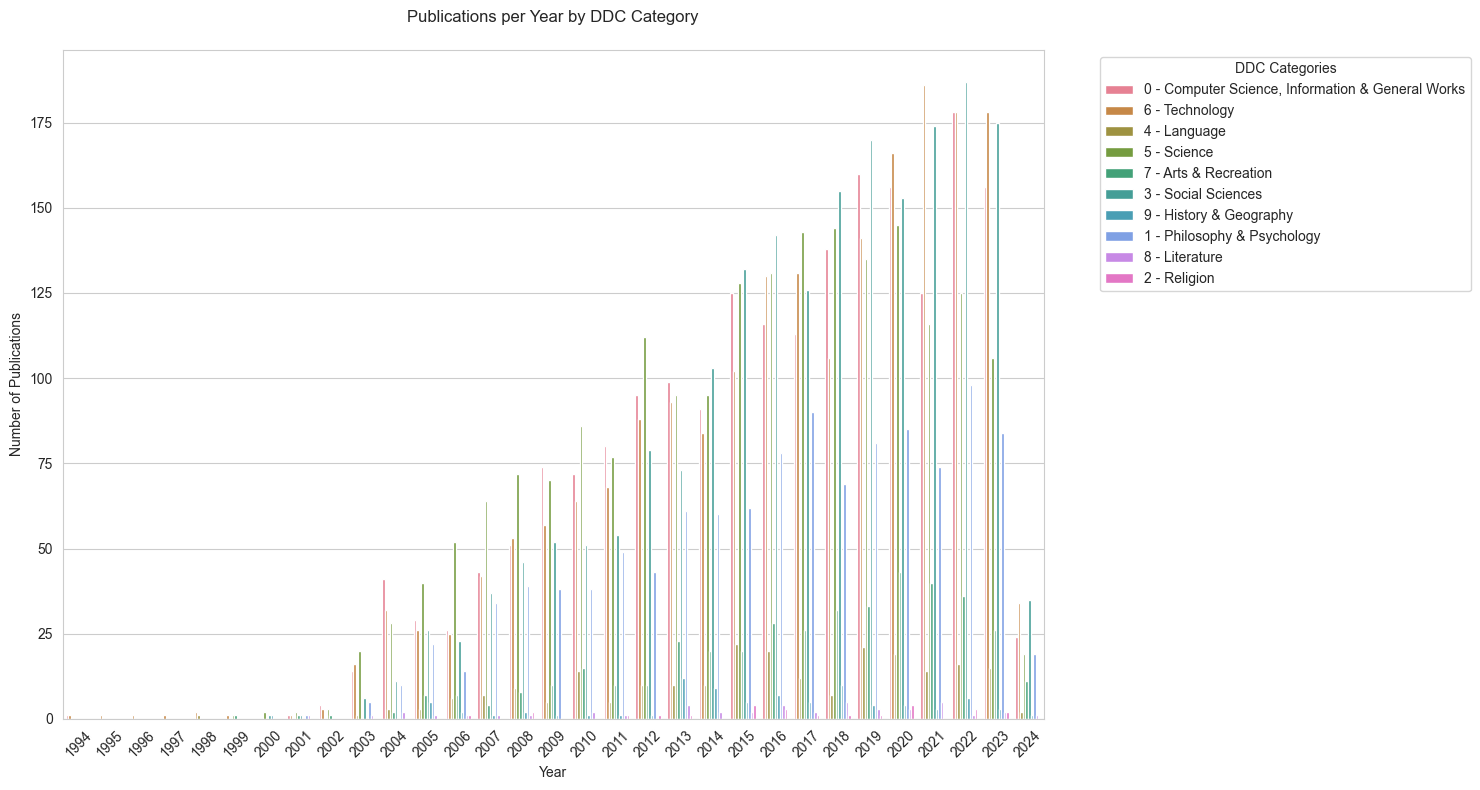

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Connect to database
conn = connect_to_db()

# Query to get the data
query = """
SELECT 
    SUBSTRING(ddc FROM 1 FOR 1) as ddc_category,
    year,
    COUNT(*) as count
FROM dnb_records_subset
WHERE year IS NOT NULL
GROUP BY SUBSTRING(ddc FROM 1 FOR 1), year
ORDER BY year, ddc_category;
"""

# Read data into DataFrame
df = pd.read_sql_query(query, conn)

# Create the plot
plt.figure(figsize=(15, 8))
sns.set_style("whitegrid")

# Create stacked bar plot
plot = sns.barplot(data=df, x="year", y="count", hue="ddc_category", palette="husl")

# Customize the plot
plt.title("Publications per Year by DDC Category", pad=20)
plt.xlabel("Year")
plt.ylabel("Number of Publications")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend with DDC category descriptions
ddc_descriptions = {
    "0": "Computer Science, Information & General Works",
    "1": "Philosophy & Psychology",
    "2": "Religion",
    "3": "Social Sciences",
    "4": "Language",
    "5": "Science",
    "6": "Technology",
    "7": "Arts & Recreation",
    "8": "Literature",
    "9": "History & Geography",
}

# Update legend labels
handles = plot.get_legend_handles_labels()[0]
labels = [f"{cat} - {ddc_descriptions[cat]}" for cat in plot.get_legend_handles_labels()[1]]
plt.legend(handles, labels, title="DDC Categories", bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Close connection
conn.close()